### Data Preparation
(read + add technical indicators + convert close prise to log returns)

In [2]:
import ta
import pandas as pd
import numpy as np

In [3]:
%%capture

data = pd.read_csv('data/stocks_s&p500/A_data.csv').rename(columns={"date": "Date", "open": "Open", "high": "High",
                                                                    "low": "Low", "close": "Close", "volume": "Volume"}).drop(['Name'], axis=1)
data['LogRet'] = np.log(data['Close']).diff()
data = ta.add_all_ta_features(
    data, open="Open", high="High", low="Low", close="LogRet", volume="Volume")
data_array = data[['LogRet', 'volume_adi', 'trend_macd', 'volatility_kcp', 'momentum_stoch_rsi', 'trend_sma_slow']].dropna().to_numpy()

print prices plot

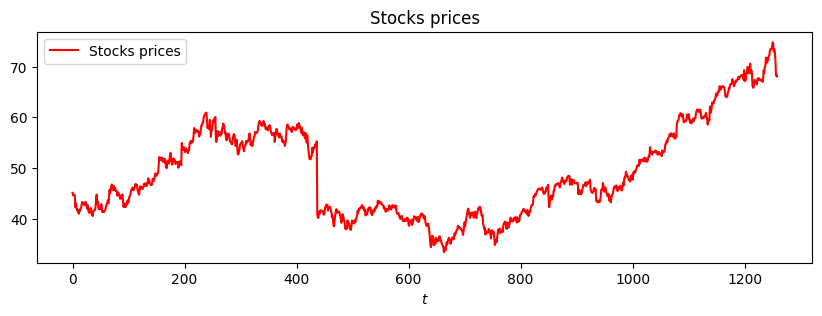

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.title("Stocks prices")
plt.xlabel("$t$")

plt.plot(data['Close'], label="Stocks prices", color="red")
plt.legend()
plt.show()

print log returns plot

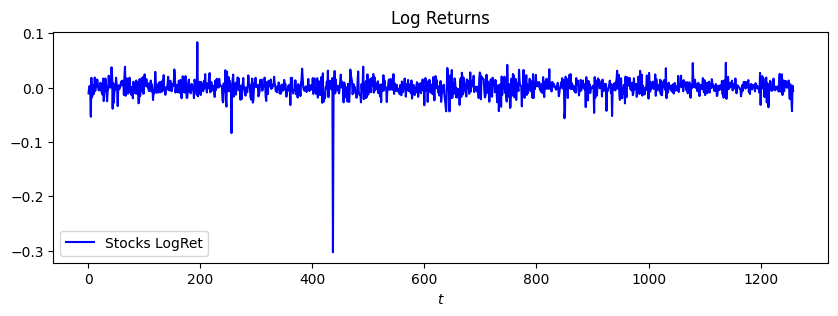

In [11]:
plt.figure(figsize=(10, 3))
plt.title("Log Returns")
plt.xlabel("$t$")

plt.plot(data['LogRet'], label="Stocks LogRet", color="blue")
plt.legend()
plt.show()

In [12]:
import statsmodels.api as sm

logrets = data['LogRet'].dropna().to_numpy()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(logrets)[1])

Dickey-Fuller test: p=0.000000


### Reservoir model

При инициализации объекта класса ESNPredictions можно выбрать: размер окна, используемого для генерации предсказаний(window_size), количество шагов предсказания(forecast_size), размер тестовой выборки(test_size) \
При вызове функции get_predictions можно указать параметр отвечающий за оптимизацию гиперпараметров модели(opt)

In [ ]:
%%capture

from models.esn import ESNPredictions

esn_preds_simple = ESNPredictions(data_array, window_size=50, forecast_size=10, test_size=0.1, model_type='simple')
Y_pred_simple = esn_preds_simple .get_predictions(opt=True)
Y_test_simple = esn_preds_simple .Y_test[:, 0][:len(Y_pred_simple)]

In [9]:
%%capture

esn_preds_deep = ESNPredictions(data_array, window_size=50, forecast_size=10, test_size=0.1, model_type='deep')
Y_pred_deep = esn_preds_deep.get_predictions(opt=True)
Y_test_deep = esn_preds_deep.Y_test[:, 0][:len(Y_pred_deep)]

In [8]:
%%capture

esn_preds_hier = ESNPredictions(data_array, window_size=50, forecast_size=10, test_size=0.1, model_type='hierarchical')
Y_pred_hier = esn_preds_hier.get_predictions(opt=True)
Y_test_hier = esn_preds_hier.Y_test[:, 0][:len(Y_pred_hier)]

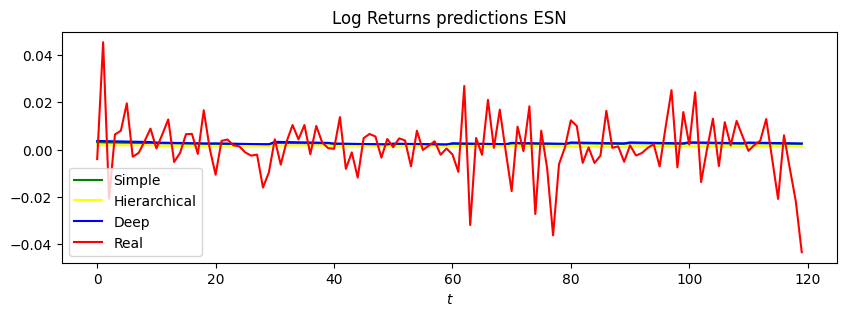

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.title("Log Returns predictions ESN")
plt.xlabel("$t$")
plt.plot(Y_pred_simple, label="Simple", color="green")
plt.plot(Y_pred_hier, label="Hierarchical", color="yellow")
plt.plot(Y_pred_deep, label="Deep", color="blue")
plt.plot(Y_test_simple, label="Real", color="red")
plt.legend()
plt.show()

In [11]:
from sklearn import metrics

mae_simple = metrics.mean_absolute_error(Y_test_simple, Y_pred_simple[:len(Y_test_simple)])
mae_deep = metrics.mean_absolute_error(Y_test_deep, Y_pred_deep[:len(Y_test_deep)])
mae_hier = metrics.mean_absolute_error(Y_test_hier, Y_pred_hier[:len(Y_test_hier)])
print('MAE для simple ESN модели:', mae_simple)
print('MAE для deep ESN модели:', mae_deep)
print('MAE для hier ESN модели:', mae_hier)

MAE для simple ESN модели: 0.008161643787892822
MAE для deep ESN модели: 0.008181875514349844
MAE для hier ESN модели: 0.008049449809658972


### Arima
При инициализации объекта класса Arimaredictions можно выбрать: количество шагов предсказания(forecast_size), размер тестовой выборки(test_size) \
При вызове функции get_predictions можно указать параметр отвечающий за оптимизацию гиперпараметров модели(opt)

In [12]:
%%capture
from models.arima import ArimaPredictions

arima = ArimaPredictions(data_array, forecast_size=10, test_size=0.1)
Y_pred_arima = arima.get_predictions(opt=True)
Y_test_arima = arima.Y_test[:len(Y_pred_arima)]

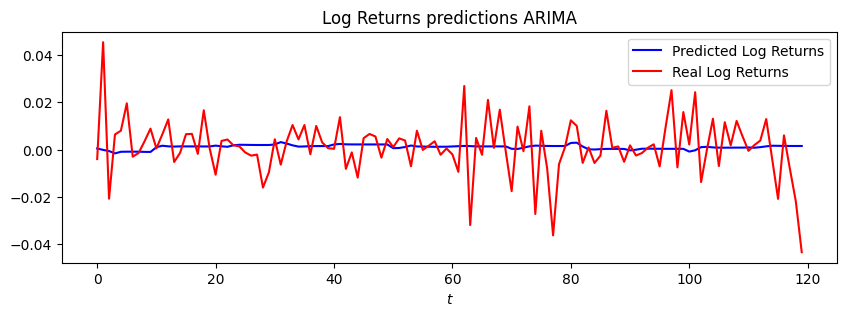

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.title("Log Returns predictions ARIMA")
plt.xlabel("$t$")
#plt.plot(Y_train, label="Predicted stocks", color="red")
plt.plot(Y_pred_arima, label="Predicted Log Returns", color="blue")
plt.plot(Y_test_arima, label="Real Log Returns", color="red")
plt.legend()
plt.show()

In [14]:
mae = metrics.mean_absolute_error(Y_test_arima, Y_pred_arima)
print('MAE для Arima модели:', mae)

MAE для Arima модели: 0.008174257800992762


### LSTM

In [15]:
%%capture
from models.lstm import LSTMPredictions

lstm = LSTMPredictions(data_array, window_size=50, forecast_size=10, test_size=0.1)
Y_pred_lstm = lstm.get_predictions(opt=True)
Y_test_lstm = lstm.Y_test_one_dim[:len(Y_pred_lstm)]

2023-12-21 14:36:15.043128: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


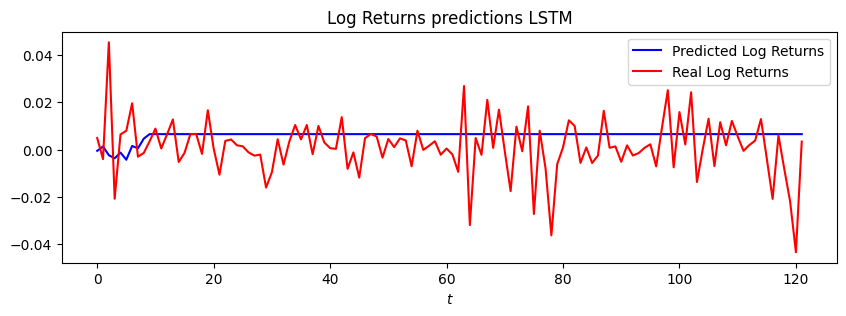

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.title("Log Returns predictions LSTM")
plt.xlabel("$t$")
#plt.plot(Y_train, label="Predicted stocks", color="red")
plt.plot(Y_pred_lstm, label="Predicted Log Returns", color="blue")
plt.plot(Y_test_lstm, label="Real Log Returns", color="red")
plt.legend()
plt.show()

In [17]:
from sklearn import metrics
mae = metrics.mean_absolute_error(Y_test_lstm, Y_pred_lstm)
print('MAE для LSTM модели:', mae)

MAE для LSTM модели: 0.00947384403953078


### GRU

In [18]:
%%capture
from models.gru import GRUPredictions

gru = GRUPredictions(data_array, window_size=100, forecast_size=3, test_size=0.1)
Y_pred_gru = gru.get_predictions(opt=True)
Y_test_gru = gru.Y_test_one_dim[:len(Y_pred_gru)]

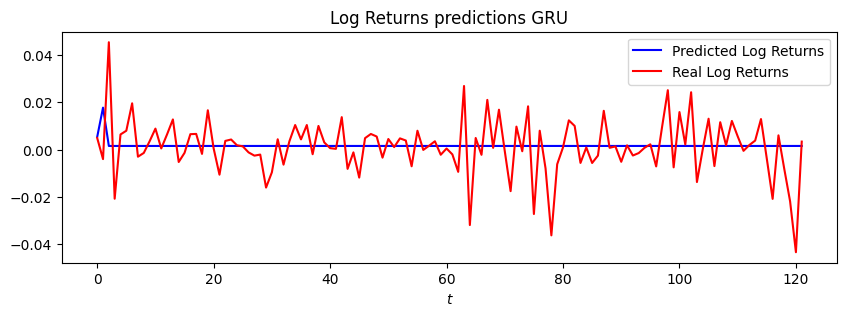

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.title("Log Returns predictions GRU")
plt.xlabel("$t$")

plt.plot(Y_pred_gru, label="Predicted Log Returns", color="blue")
plt.plot(Y_test_gru, label="Real Log Returns", color="red")
plt.legend()
plt.show()

In [20]:
from sklearn import metrics
mae = metrics.mean_absolute_error(Y_test_gru, Y_pred_gru)
print('MAE для GRU модели:', mae)

MAE для GRU модели: 0.008090537742534392


### Stocks

In [21]:
Y_real = data['Close'][-len(Y_pred_simple):].values
Y_price_simple=np.multiply(Y_real, np.exp(Y_pred_simple))
Y_price_deep=np.multiply(Y_real, np.exp(Y_pred_deep))
Y_price_hier=np.multiply(Y_real, np.exp(Y_pred_hier))
Y_price_lstm=np.multiply(Y_real, np.exp(Y_pred_lstm)[:len(Y_real)])
Y_price_gru=np.multiply(Y_real, np.exp(Y_pred_gru)[:len(Y_real)])
Y_price_arima=np.multiply(Y_real, np.exp(Y_pred_arima)[:len(Y_real)])

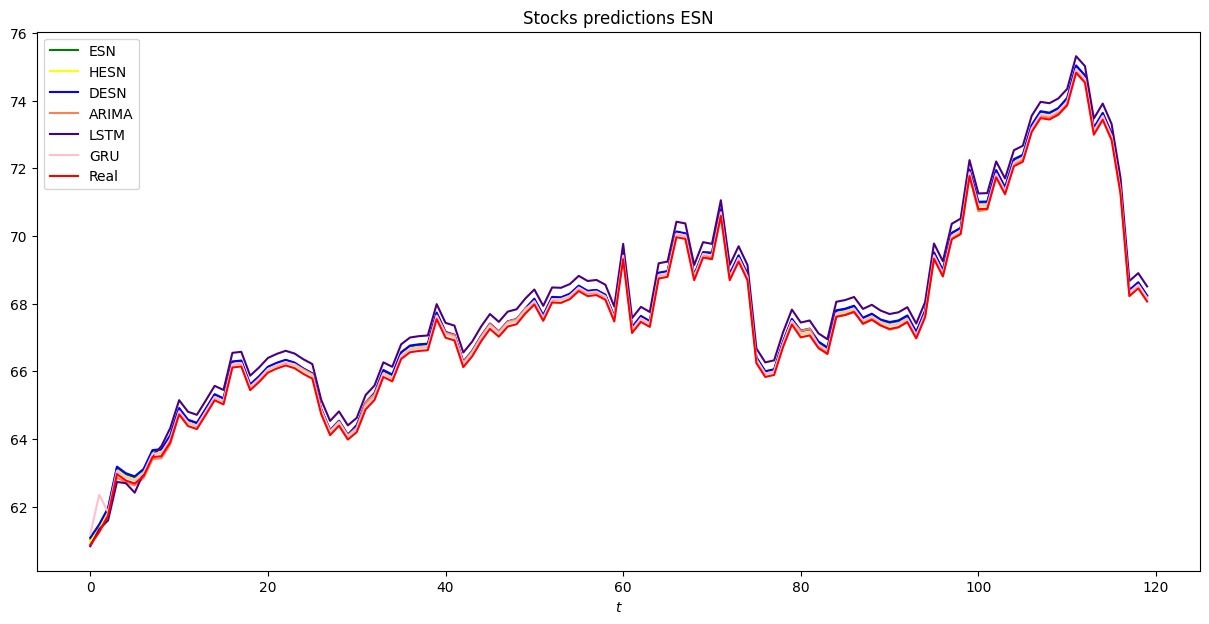

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.title("Stocks predictions ESN")
plt.xlabel("$t$")
plt.plot(Y_price_simple, label="ESN", color="green")
plt.plot(Y_price_hier, label="HESN", color="yellow")
plt.plot(Y_price_deep, label="DESN", color="blue")
plt.plot(Y_price_arima, label="ARIMA", color="coral")
plt.plot(Y_price_lstm, label="LSTM", color="indigo")
plt.plot(Y_price_gru, label="GRU", color="pink")
plt.plot(Y_real, label="Real", color="red")
plt.legend()
plt.show()

In [23]:
mae_simple = metrics.mean_absolute_error(Y_real, Y_price_simple)
mae_deep = metrics.mean_absolute_error(Y_real, Y_price_deep)
mae_hier = metrics.mean_absolute_error(Y_real, Y_price_hier)
mae_arima = metrics.mean_absolute_error(Y_real, Y_price_arima)
mae_lstm = metrics.mean_absolute_error(Y_real, Y_price_lstm)
mae_gru = metrics.mean_absolute_error(Y_real, Y_price_gru)
print('MAE для simple ESN модели:', mae_simple)
print('MAE для deep ESN модели:', mae_deep)
print('MAE для hier ESN модели:', mae_hier)
print('MAE для arima модели:', mae_arima)
print('MAE для lstm модели:', mae_lstm)
print('MAE для gru модели:', mae_gru)

MAE для simple ESN модели: 0.1680859766917692
MAE для deep ESN модели: 0.18421518590768357
MAE для hier ESN модели: 0.09975802526723125
MAE для arima модели: 0.08389929677553726
MAE для lstm модели: 0.4222662711242834
MAE для gru модели: 0.11343283523122416
